In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Models the ringdown of a black hole from Numerical Relativity (NR) waveforms.

This script implements a method to model the ringdown of a black hole using
quasinormal modes (QNMs). It smoothly matches a QNM model to an NR waveform
from the SXS catalog at a user-specified time.

The key steps are:
1. Download a gravitational waveform from the SXS catalog.
2. Rotate the waveform to the frame of the remnant black hole to separate harmonics.
3. Calculate the QNM frequencies using the remnant black hole's properties.
4. Construct a ringdown model by matching the waveform and its derivatives at a
   given time `t0`.
5. Quantify the error of the model using a mismatch calculation.
"""

import sxs
import numpy as np
import spherical_functions as sf
import qnm
import quaternionic
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

def construct_ringdown_model(h_lm, times, t0, qnm_freqs, n_overtones):
    """
    Constructs a ringdown model for a single (l,m) mode.

    The model is constructed by solving a linear system that matches the
    waveform's value and its first `n_overtones - 1` derivatives at time `t0`.

    Args:
        h_lm (np.ndarray): The complex strain of a single (l,m) mode.
        times (np.ndarray): The time array corresponding to h_lm.
        t0 (float): The time at which to match the NR waveform.
        qnm_freqs (list): A list of complex QNM frequencies [omega_n].
        n_overtones (int): The number of QNM overtones to include in the model.

    Returns:
        tuple: (ringdown_waveform, coefficients)
               - ringdown_waveform (np.ndarray): The modeled ringdown waveform.
               - coefficients (np.ndarray): The complex coefficients (D_n).
    """
    if n_overtones == 0:
        return np.zeros_like(h_lm), np.array([])

    # Create splines to smoothly compute derivatives of the waveform.
    spl_real = UnivariateSpline(times, h_lm.real, s=0, k=5)
    spl_imag = UnivariateSpline(times, h_lm.imag, s=0, k=5)

    # We solve the linear system M * D = V for the complex coefficients D_n,
    # where the model is Sum(D_n * exp(-i*omega_n*(t-t0))).
    num_derivatives = n_overtones

    # Vector V: waveform derivatives at t0
    V = np.zeros(num_derivatives, dtype=complex)
    for k in range(num_derivatives):
        V[k] = spl_real.derivative(n=k)(t0) + 1j * spl_imag.derivative(n=k)(t0)

    # Matrix M: M_ij = (-i*omega_j)^i
    M = np.zeros((num_derivatives, n_overtones), dtype=complex)
    for i in range(num_derivatives):  # derivative order
        for j in range(n_overtones):  # overtone number
            omega = qnm_freqs[j]
            M[i, j] = (-1j * omega)**i

    # Solve the linear system for the coefficients D
    try:
        coeffs, _, _, _ = np.linalg.lstsq(M, V, rcond=None)
    except np.linalg.LinAlgError:
        print("Error: Could not solve for QNM coefficients. Matrix may be singular.")
        return np.zeros_like(h_lm), np.array([])

    # Construct the ringdown waveform model for t >= t0
    t_ringdown = times[times >= t0]
    h_ringdown = np.zeros_like(t_ringdown, dtype=complex)
    for n in range(n_overtones):
        omega = qnm_freqs[n]
        h_ringdown += coeffs[n] * np.exp(-1j * omega * (t_ringdown - t0))

    # Place the model into a full-time array
    full_ringdown_waveform = np.zeros_like(h_lm, dtype=complex)
    start_index = np.searchsorted(times, t0)
    full_ringdown_waveform[start_index:] = h_ringdown

    return full_ringdown_waveform, coeffs

def calculate_mismatch(h1, h2, times, t0):
    """
    Calculates the mismatch between two waveforms after a given time t0.

    Mismatch is defined as 1 - overlap, where overlap is the noise-weighted
    inner product, maximized over time and phase. Here, a simple inner
    product with a uniform noise curve (white noise) is used.

    Args:
        h1 (np.ndarray): First waveform (e.g., NR data).
        h2 (np.ndarray): Second waveform (e.g., ringdown model).
        times (np.ndarray): Time array.
        t0 (float): Start time for the integration.

    Returns:
        float: The mismatch value.
    """
    # Integrate only for times t >= t0
    integration_indices = times >= t0
    h1_int = h1[integration_indices]
    h2_int = h2[integration_indices]
    t_int = times[integration_indices]

    if len(t_int) < 2:
        return 1.0  # Cannot compute mismatch if there's no overlap duration

    # Inner product: <h1|h2> = integral(h1 * conj(h2)) dt
    integrand = h1_int * np.conj(h2_int)
    inner_product = np.trapezoid(integrand, t_int)

    # Norms: |h|^2 = <h|h>
    norm1_sq = np.trapezoid(np.abs(h1_int)**2, t_int)
    norm2_sq = np.trapezoid(np.abs(h2_int)**2, t_int)

    if norm1_sq == 0 or norm2_sq == 0:
        return 1.0

    # Overlap is the normalized inner product
    overlap = np.abs(inner_product) / np.sqrt(norm1_sq * norm2_sq)
    mismatch = 1.0 - overlap
    return mismatch

In [30]:
"""
Main function to execute the black hole ringdown analysis workflow.
"""
# --- User-specifiable parameters ---
sxs_id = "SXS:BBH:0305"
l_max = 4
n_overtones = 3 # Number of overtones to use in the model
# Time to start the ringdown model (in units of M).
# A number (e.g., 10.0) sets the time offset from the peak of the (2,2) mode.
t0_offset = 10.0

plt.style.use('seaborn-v0_8-darkgrid')

# 1. Download Numerical Relativity Waveform
print(f"Downloading data for {sxs_id}...")
simulation = sxs.load(sxs_id, download=True)

waveform = simulation.h
metadata = simulation.metadata
print("Download complete.")


# 2. Rotate Waveform to the Remnant Black Hole Frame
print("Rotating waveform to remnant frame...")
remnant_spin = metadata["remnant_dimensionless_spin"]
spin_mag = np.linalg.norm(remnant_spin)
spin_dir = remnant_spin / spin_mag if spin_mag > 1e-9 else np.array([0, 0, 1])

z_axis = np.array([0, 0, 1])
if np.allclose(z_axis, spin_dir):
    # No rotation needed, create an identity quaternion
    rotation_quaternion = quaternionic.one
else:
    rotation_axis = np.cross(z_axis, spin_dir)
    rotation_angle = np.arccos(np.dot(z_axis, spin_dir))
    
    # The `from_axis_angle` method expects a single 3-vector where the
    # direction is the rotation axis and the magnitude is the rotation angle.
    rotation_vector = rotation_axis / np.linalg.norm(rotation_axis) * rotation_angle
    rotation_quaternion = quaternionic.array.from_axis_angle(rotation_vector)

h_rotated = waveform.rotate(rotation_quaternion)
times = waveform.t
print("Rotation complete.")

# 3. Calculate Quasinormal Mode Frequencies
print(f"Calculating QNM frequencies for l <= {l_max}...")
qnm_omegas = {}
chi = spin_mag
for l in range(2, l_max + 1):
    for m in range(-l, l + 1):
        # FIX: The qnm library API has changed. We now instantiate a KerrMode
        # object for each overtone `n` and call it to get the frequency.
        omegas_for_lm = []
        for n in range(n_overtones):
            for sign in [1,-1]:
                # NOTE: The spin parameter is 'a', not 'chi'
                kerr_mode = qnm.modes_cache(s=-2,l=l,m=sign*m,n=n)
                omega, _, _ = kerr_mode(a=chi) # The object is callable
                if sign == 1:
                    omegas_for_lm.append(omega)
                else:
                    omegas_for_lm.append(-np.conjugate(omega))
        qnm_omegas[(l, m)] = omegas_for_lm

# FIX: Update how the example frequency is accessed
omega_220 = qnm_omegas[(2, 2)][0]
print(f"Example: The (2,2,0) mode frequency is {omega_220:.4f}")

# 4. Construct the Ringdown Waveform
# Determine the matching time t0
h_22 = h_rotated.data[:, h_rotated.index(2, 2)]
peak_time = times[np.argmax(np.abs(h_22))]
t0 = peak_time + t0_offset

print(f"\nConstructing ringdown models with n={n_overtones} overtones...")
print(f"Matching time t0 set to: {t0:.2f} M ({t0_offset} M after peak)")

ringdown_models = {}
for l in range(2, l_max + 1):
    for m in range(-l, l + 1):
        mode_idx = h_rotated.index(l, m)
        h_lm = h_rotated.data[:, mode_idx]
        
        # FIX: The omegas are now directly in the dictionary
        omegas = qnm_omegas[(l, m)]
        
        model, _ = construct_ringdown_model(h_lm, times, t0, omegas, n_overtones*2)
        ringdown_models[(l, m)] = model
        print(f"Constructed model for (l,m)=({l},{m})")

Download complete.
Rotating waveform to remnant frame...
Rotation complete.
Calculating QNM frequencies for l <= 4...
Example: The (2,2,0) mode frequency is 0.5291-0.0811j

Constructing ringdown models with n=3 overtones...
Matching time t0 set to: 3702.65 M (10.0 M after peak)
Constructed model for (l,m)=(2,-2)
Constructed model for (l,m)=(2,-1)
Constructed model for (l,m)=(2,0)
Constructed model for (l,m)=(2,1)
Constructed model for (l,m)=(2,2)
Constructed model for (l,m)=(3,-3)
Constructed model for (l,m)=(3,-2)
Constructed model for (l,m)=(3,-1)
Constructed model for (l,m)=(3,0)
Constructed model for (l,m)=(3,1)
Constructed model for (l,m)=(3,2)
Constructed model for (l,m)=(3,3)
Constructed model for (l,m)=(4,-4)
Constructed model for (l,m)=(4,-3)
Constructed model for (l,m)=(4,-2)
Constructed model for (l,m)=(4,-1)
Constructed model for (l,m)=(4,0)
Constructed model for (l,m)=(4,1)
Constructed model for (l,m)=(4,2)
Constructed model for (l,m)=(4,3)
Constructed model for (l,m)=(4,4


Calculating mismatch for each mode:
Mismatch for (l,m)=(2,-2): 7.13e-03
Mismatch for (l,m)=(2,-1): 1.21e-02
Mismatch for (l,m)=(2,0): 8.27e-01
Mismatch for (l,m)=(2,1): 7.37e-03
Mismatch for (l,m)=(2,2): 7.33e-03
Mismatch for (l,m)=(3,-3): 1.34e-02
Mismatch for (l,m)=(3,-2): 1.47e-01
Mismatch for (l,m)=(3,-1): 2.85e-01
Mismatch for (l,m)=(3,0): 3.57e-01
Mismatch for (l,m)=(3,1): 2.77e-01
Mismatch for (l,m)=(3,2): 1.46e-01
Mismatch for (l,m)=(3,3): 1.31e-02
Mismatch for (l,m)=(4,-4): 1.40e-02
Mismatch for (l,m)=(4,-3): 6.83e-02
Mismatch for (l,m)=(4,-2): 2.87e-01
Mismatch for (l,m)=(4,-1): 3.67e-01
Mismatch for (l,m)=(4,0): 9.73e-01
Mismatch for (l,m)=(4,1): 3.42e-01
Mismatch for (l,m)=(4,2): 2.89e-01
Mismatch for (l,m)=(4,3): 6.94e-02
Mismatch for (l,m)=(4,4): 1.40e-02


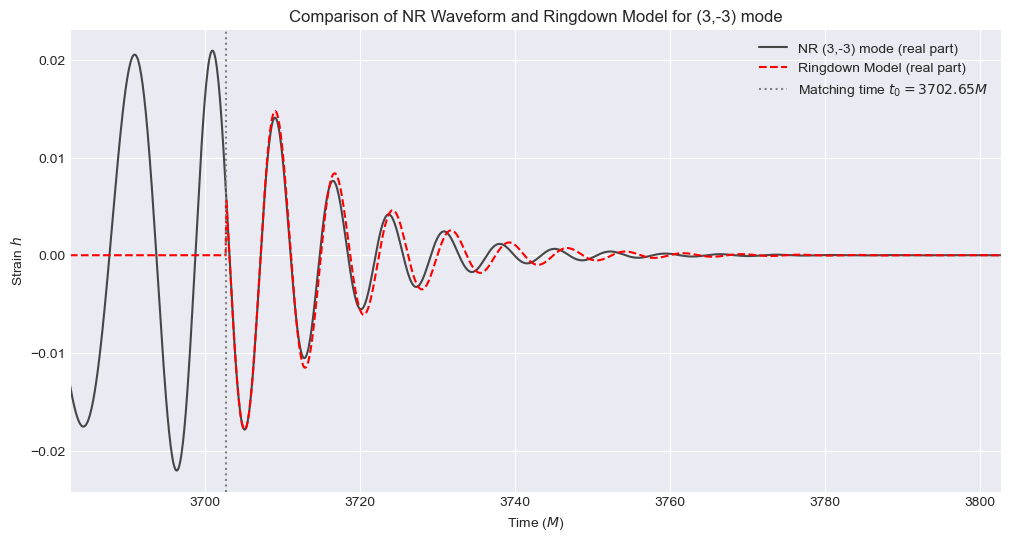

In [31]:

# 5. Visualize the Ringdown Model for the (2,2) mode
l, m = 3, -3
h_lm_nr = h_rotated.data[:, h_rotated.index(l, m)]
h_lm_model = ringdown_models[(l, m)]

plt.figure(figsize=(12, 6))
plt.plot(times, h_lm_nr.real, label=f'NR ({l},{m}) mode (real part)', color='k', alpha=0.7)
plt.plot(times, h_lm_model.real, label=f'Ringdown Model (real part)', color='r', linestyle='--')
plt.axvline(t0, color='gray', linestyle=':', label=f'Matching time $t_0 = {t0:.2f} M$')
plt.xlim(t0 - 20, t0 + 100)
plt.xlabel("Time ($M$)")
plt.ylabel("Strain $h$")
plt.title(f"Comparison of NR Waveform and Ringdown Model for ({l},{m}) mode")
plt.legend()

# 6. Quantify the Error with Mismatch
print("\nCalculating mismatch for each mode:")
for l in range(2, l_max + 1):
    for m in range(-l, l + 1):
        h_lm_nr = h_rotated.data[:, h_rotated.index(l, m)]
        h_lm_model = ringdown_models[(l, m)]
        
        mismatch = calculate_mismatch(h_lm_nr, h_lm_model, times, t0)
        print(f"Mismatch for (l,m)=({l},{m}): {mismatch:.2e}")
        
# Show the plot after all calculations are done
plt.show()